In [40]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
colors = ['#809a4b', '#6f7d88']
model_order = ['0', '20', '100']
bg = '#fcfff3'

In [42]:
trans_dataset_list = ['0', '20', '100']
models = ['rtdetr-l-coco-torch', 'yolov8m-world-torch']
results = {}

for t in trans_dataset_list:
    results[t] = {}
    for model in models:
        with open(f'evaluation/transdata_{t}_n25_{model}_results.json', 'r') as f:
            results[t][model] = json.load(f)
        

In [55]:
results.keys()

dict_keys(['0', '20', '100'])

In [43]:
results['0']['rtdetr-l-coco-torch'].keys()

dict_keys(['og_dataset', 'trans_dataset', 'model_name', 'affected_dict', 'affected_perc', 'threshold_list', 'affected_scores', 'og_metrics', 'trans_metrics', 'overall_og_mean_metrics', 'overall_trans_mean_metrics', 'trans_obj_metrics', 'overall_obj_metrics', 'matching_scores', 'overall_mean_matching_score', 'overall_mean_affected_matching_score'])

In [44]:
type(results['0']['rtdetr-l-coco-torch']['overall_trans_mean_metrics'])

dict

In [45]:
type(results['0']['rtdetr-l-coco-torch']['og_dataset'])

str

In [46]:
def get_df(overlap_result, metric_name):
    # makes a df wit the result for a single dataset (e.g. trans_0), for a single metric
    data = {}
    index_needed=False
    for model in overlap_result:
        data[model] = {}
        print(overlap_result[model][metric_name])
        if type(overlap_result[model][metric_name]) == dict:
            for additional_metric in overlap_result[model][metric_name]:
                data[model][additional_metric] = overlap_result[model][metric_name][additional_metric]
        else:
            index_needed=True
            data[model] = overlap_result[model][metric_name]
    print(data)
    if index_needed:
        df = pd.DataFrame(data, index=[metric_name])
    else:
        df = pd.DataFrame(data)
    return df

In [47]:
def plot_difference(df1, df2, metric_name):
    if df1.shape != df2.shape:
        raise ValueError("DataFrames must have the same shape to calculate differences.")

    # Calculate the difference between the two DataFrames
    difference_df = df1 - df2

    # Create the bar plot for the differences
    difference_df.plot(kind='bar', figsize=(10, 6), color=colors)

    # Customize the plot
    plt.xlabel('Evaluation Index')
    plt.ylabel(f'Difference in {metric_name}')
    plt.title(f'Difference in {metric_name} Between Two DataFrames')
    plt.legend(title='Model')
    
    # Show the plot
    plt.show()

    return difference_df

In [56]:
def plot_bar_perf(metric_name, overlap_result):
    data = get_df(overlap_result, metric_name)
    data.plot(kind='bar', figsize=(6, 4), color=colors)

    # Customize the plot
    plt.xlabel('Evaluation Index')
    plt.ylabel(metric_name)
    plt.title(f'Comparison of Performance on Original Images across Models')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Show the plot
    plt.show()

# plot_bar_perf('overall_og_mean_metrics', results['0'], )

{'conf': 0.6078692562544754, 'f1': 0.6493827464818176}
{'conf': 0.6697467167558687, 'f1': 0.6737664449371766}
{'rtdetr-l-coco-torch': {'conf': 0.6078692562544754, 'f1': 0.6493827464818176}, 'yolov8m-world-torch': {'conf': 0.6697467167558687, 'f1': 0.6737664449371766}}
{'conf': 0.6123975442334566, 'f1': 0.6656064710338794}
{'conf': 0.7083849251524864, 'f1': 0.6939745508042043}
{'rtdetr-l-coco-torch': {'conf': 0.6123975442334566, 'f1': 0.6656064710338794}, 'yolov8m-world-torch': {'conf': 0.7083849251524864, 'f1': 0.6939745508042043}}
{'conf': 0.6139597896399959, 'f1': 0.6456973241099352}
{'conf': 0.6910418391735593, 'f1': 0.6700736369871612}
{'rtdetr-l-coco-torch': {'conf': 0.6139597896399959, 'f1': 0.6456973241099352}, 'yolov8m-world-torch': {'conf': 0.6910418391735593, 'f1': 0.6700736369871612}}
{'conf': 0.5946739388744349, 'f1': 0.5579765213638352}
{'conf': 0.6646656868838423, 'f1': 0.5679594313114886}
{'rtdetr-l-coco-torch': {'conf': 0.5946739388744349, 'f1': 0.5579765213638352}, 'yo

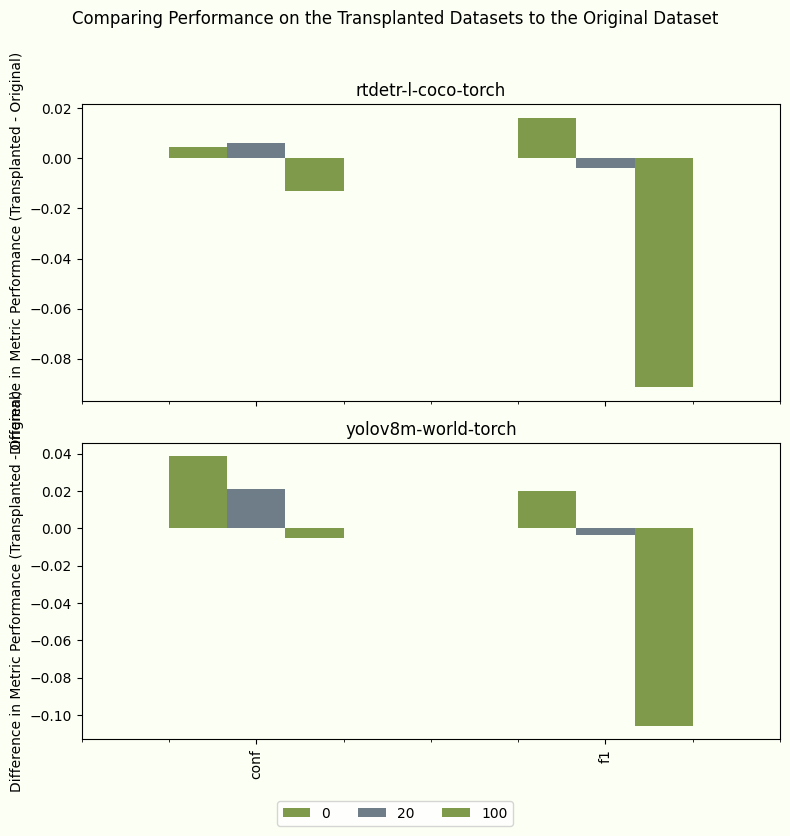

In [89]:
def plot_difference_mult_pivoted(metric_name, df_pairs, overlap_titles):
    n = df_pairs[0][0].shape[1]  # Number of metrics
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 4 * n), sharex=True)

    combined_handles, combined_labels = None, None

    for i in range(n):  # Loop over each metric
        metric = df_pairs[0][0].columns[i]  # Get metric name
        differences = []

        # Loop through pairs and compute the differences for the current metric
        for df1, df2 in df_pairs:
            difference = df2[metric] - df1[metric]  # Compute difference for this metric
            differences.append(difference)

        differences_df = pd.DataFrame(differences, index=overlap_titles).T

        # Plot the difference for this metric
        ax = differences_df.plot(kind='bar', ax=axes[i], legend=False, color=colors)
        ax.set_facecolor(bg)

        # Customize the subplot
        axes[i].set_title(f'{metric}')
        if i == len(df_pairs) - 1:
            axes[i].set_xlabel('Allowed Overlap (%)')
        axes[i].set_ylabel(f'Difference in {metric_name} (Transplanted - Original)')

        # Collect legend handles and labels from the first subplot
        if i == 0:
            combined_handles, combined_labels = ax.get_legend_handles_labels()

    fig.suptitle("Comparing Performance on the Transplanted Datasets to the Original Dataset")

    # Set a single legend for the entire figure
    fig.legend(combined_handles, combined_labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(overlap_titles))
    fig.patch.set_facecolor(bg)

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plot
    plt.show()


og_perf = get_df(results['0'], 'overall_og_mean_metrics')
trans_0_perf = get_df(results['0'], 'overall_trans_mean_metrics')
trans_20_perf = get_df(results['20'], 'overall_trans_mean_metrics')
trans_100_perf = get_df(results['100'], 'overall_trans_mean_metrics')

df_pairs = [(og_perf, trans_0_perf), (og_perf, trans_20_perf), (og_perf, trans_100_perf)]

plot_difference_mult_pivoted('Metric Performance', df_pairs, ['0', '20', '100'])


{'conf': 0.6078692562544754, 'f1': 0.6493827464818176}
{'conf': 0.6697467167558687, 'f1': 0.6737664449371766}
{'rtdetr-l-coco-torch': {'conf': 0.6078692562544754, 'f1': 0.6493827464818176}, 'yolov8m-world-torch': {'conf': 0.6697467167558687, 'f1': 0.6737664449371766}}
{'conf': 0.6123975442334566, 'f1': 0.6656064710338794}
{'conf': 0.7083849251524864, 'f1': 0.6939745508042043}
{'rtdetr-l-coco-torch': {'conf': 0.6123975442334566, 'f1': 0.6656064710338794}, 'yolov8m-world-torch': {'conf': 0.7083849251524864, 'f1': 0.6939745508042043}}
{'conf': 0.6139597896399959, 'f1': 0.6456973241099352}
{'conf': 0.6910418391735593, 'f1': 0.6700736369871612}
{'rtdetr-l-coco-torch': {'conf': 0.6139597896399959, 'f1': 0.6456973241099352}, 'yolov8m-world-torch': {'conf': 0.6910418391735593, 'f1': 0.6700736369871612}}
{'conf': 0.5946739388744349, 'f1': 0.5579765213638352}
{'conf': 0.6646656868838423, 'f1': 0.5679594313114886}
{'rtdetr-l-coco-torch': {'conf': 0.5946739388744349, 'f1': 0.5579765213638352}, 'yo

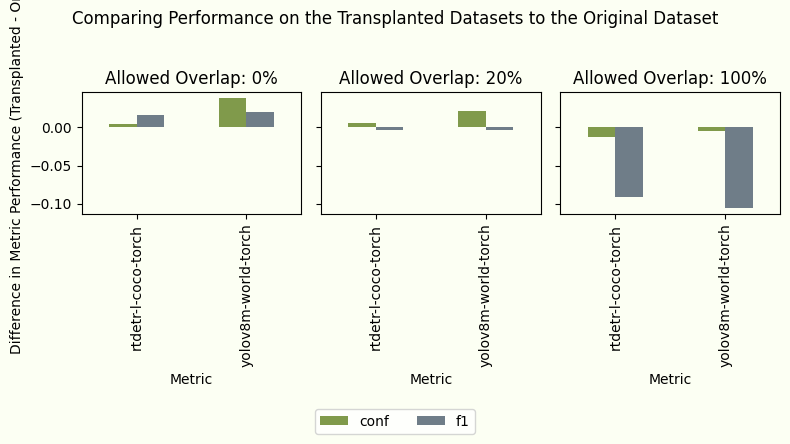

In [88]:

def plot_difference_mult(metric_name, df_pairs, titles):
    n = len(df_pairs)
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(8, 4), sharey=True)

    combined_handles, combined_labels = None, None
    for i, (df1, df2) in enumerate(df_pairs):
        if df1.shape != df2.shape:
            raise ValueError("DataFrames must have the same shape to calculate differences.")

        # Calculate the difference between the two DataFrames
        difference_df = df2 - df1

        # Plot the DataFrame on the respective subplot
      
        ax = difference_df.plot(kind='bar', ax=axes[i], legend=False, color=colors)
        ax.set_facecolor(bg)
        
        # Customize the subplot
        axes[i].set_title(f'Allowed Overlap: {titles[i]}%')
        axes[i].set_xlabel('Metric')
        if i == 0:
            axes[i].set_ylabel(f'Difference in {metric_name} (Transplanted - Original)')
        
        # Collect legend handles and labels from the last subplot
        if i == 0:
            combined_handles, combined_labels = ax.get_legend_handles_labels()
    fig.suptitle("Comparing Performance on the Transplanted Datasets to the Original Dataset")
    # Set a single legend for the entire figure
    fig.legend(combined_handles, combined_labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=n)
    fig.patch.set_facecolor(bg)

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plot
    plt.show()

og_perf = get_df(results['0'], 'overall_og_mean_metrics')
trans_0_perf = get_df(results['0'], 'overall_trans_mean_metrics')
trans_20_perf = get_df(results['20'], 'overall_trans_mean_metrics')
trans_100_perf = get_df(results['100'], 'overall_trans_mean_metrics')
df_pairs = [(og_perf, trans_0_perf), (og_perf, trans_20_perf), (og_perf, trans_100_perf)]
# print(df_pairs)

plot_difference_mult('Metric Performance', df_pairs, ['0', '20', '100'])
# switch the overlap % and the metrics

In [50]:
def get_df_transposed(overlap_result, metric_name):
    # makes a df wit the result for a single dataset (e.g. trans_0), for a single metric
    data = {}
    for additional_metric in overlap_result['yolov8m-world-torch'][metric_name]:
        data[additional_metric] = {}
        for model in overlap_result:
            data[additional_metric][model] = overlap_result[model][metric_name]
            data[additional_metric][model] = overlap_result[model][metric_name][additional_metric]
    df = pd.DataFrame(data)
    print(df)
    return df

In [51]:
def plot_bar_perf_mult(metric_name, overlap_results):
    fig, axes = plt.subplots(nrows=1, ncols=len(overlap_results), figsize=(10, 5), sharey=True)
    
    combined_data = {}
    for i, overlap in enumerate(overlap_results): # This needs to be over the [0.3, 0.5, 0.95, 0.99]
        overlap_result_index = overlap
        overlap_result = overlap_results[overlap]
        df = get_df_transposed(overlap_result, metric_name)
        df.plot(kind='bar', ax=axes[i], legend=False, color=colors)
        
        # Customize the subplot
        axes[i].set_title(f'Allowed Overlap: {overlap_result_index}%')
        axes[i].set_xlabel('Performance Metric')
        if i == 0:
            axes[i].set_ylabel('Metric Performance')
        
        # Collect legend handles and labels
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()
    
    # Set a single legend for the entire figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(overlap_results))

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.title(f"Model Performance on Dataset")
    
    # Show the plot
    plt.show()

# plot_bar_perf_mult('affected_perc', results)

In [52]:
def plot_bar_perf_mult(metric_name, overlap_results, metric_display_name='Mean Matching Score'):
    fig, axes = plt.subplots(nrows=1, ncols=len(overlap_results), figsize=(10, 5), sharey=True)
    
    combined_data = {}
    for i, overlap in enumerate(overlap_results):
        overlap_result_index = overlap
        overlap_result = overlap_results[overlap]
        df = get_df(overlap_result, metric_name)
        df = df.rename(index={metric_name: metric_display_name})
        df.plot(kind='bar', ax=axes[0], legend=False, color=colors)
        
        # Customize the subplot
        axes[i].set_title(f'Allowed Overlap: {overlap_result_index}%')
        axes[i].set_xlabel('Performance Metric')
        if i == 0:
            axes[i].set_ylabel('Metric Performance')
        
        # Collect legend handles and labels
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()
    
    # Set a single legend for the entire figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(overlap_results))

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.title(f"Model Performance on Dataset")
    
    # Show the plot
    plt.show()
    
# plot_bar_perf_mult('overall_mean_matching_score', results)

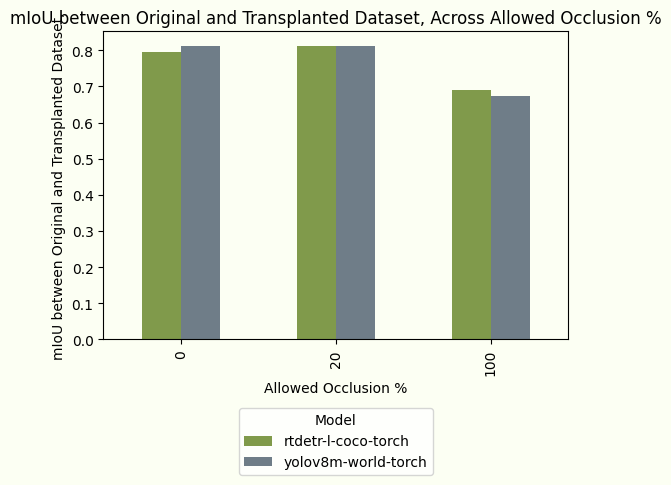

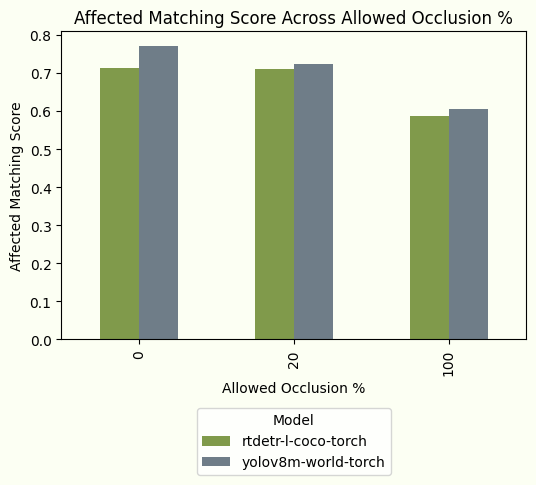

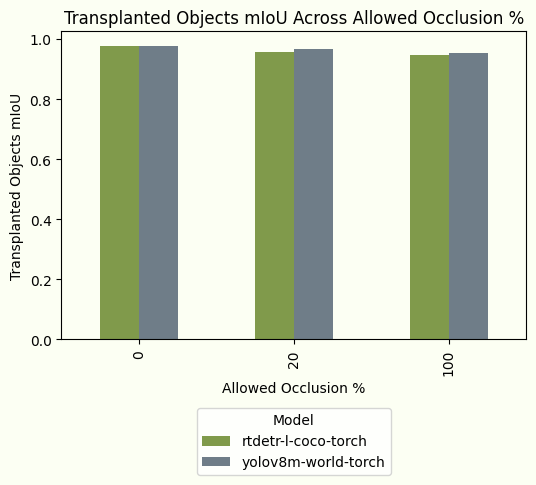

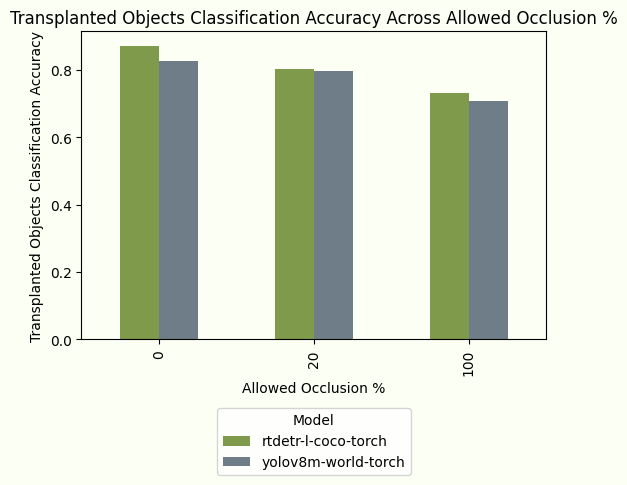

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

def extract_metrics(results, metric, addition=None):
    data = []
    for dataset, models in results.items():
        for model, metrics in models.items():
            if addition is None:
                data.append([dataset, model, metrics[metric]])
            else:
                data.append([dataset, model, metrics[metric][addition]])
    
    df = pd.DataFrame(data, columns=['Dataset', 'Model', 'Metric'])
    return df

def plot_grouped_bar(df, metric_name):
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.patch.set_facecolor(bg)
    df['Dataset'] = pd.Categorical(df['Dataset'], categories=model_order, ordered=True)
    # df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)
    df = df.sort_values(['Dataset', 'Model'])
    
    # Pivot data for plotting
    df_pivot = df.pivot(index='Dataset', columns='Model', values='Metric')
    
    # Plot grouped bar chart
    df_pivot.plot(kind='bar', ax=ax, color=colors)
    
    # Customize the plot
    ax.set_xlabel('Allowed Occlusion %')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} Across Allowed Occlusion %')
    ax.legend(title='Model', loc='upper center', bbox_to_anchor=(.5, -0.2))
    ax.set_facecolor(bg)
    # ax.legend(title='Model', loc='upper right', bbox_to_anchor=(1.45, 1))
    # Show the plot
    plt.show()

# Example usage:
# Assuming your results dictionary is already defined
df_metrics = extract_metrics(results, 'overall_mean_matching_score')
plot_grouped_bar(df_metrics, "mIoU between Original and Transplanted Dataset,")

df_metrics = extract_metrics(results, 'overall_mean_affected_matching_score')
plot_grouped_bar(df_metrics, "Affected Matching Score")

df_metrics = extract_metrics(results, 'overall_obj_metrics', 'iou')
plot_grouped_bar(df_metrics, "Transplanted Objects mIoU")

df_metrics = extract_metrics(results, 'overall_obj_metrics', 'cc')
plot_grouped_bar(df_metrics, "Transplanted Objects Classification Accuracy")

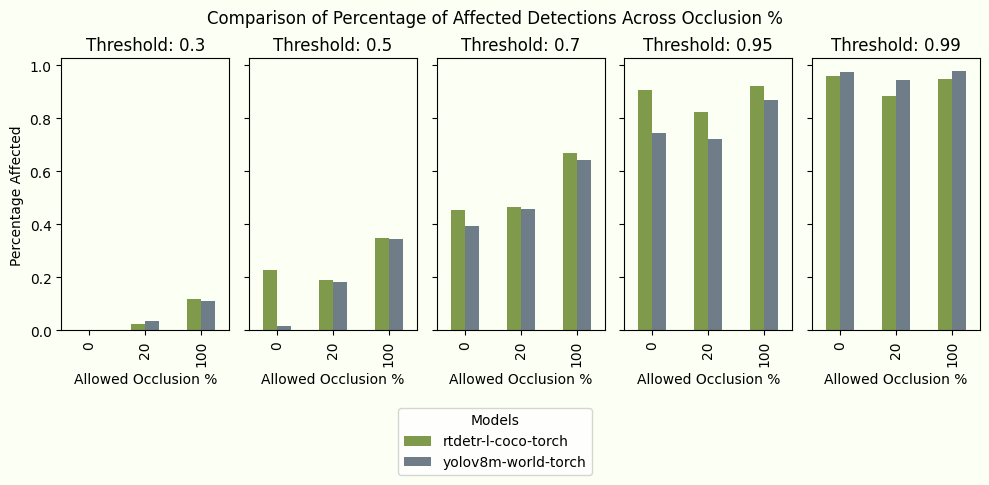

In [84]:
def plot_affected_perc_mult(results):
    affected_values = ["0.3", "0.5", "0.7", "0.95", "0.99"]
    fig, axes = plt.subplots(nrows=1, ncols=len(affected_values), figsize=(10, 4), sharey=True)

    for i, affected_val in enumerate(affected_values):
        combined_data = {}
        for dataset in results:
            combined_data[dataset] = {}
            for model in results[dataset]:
                combined_data[dataset][model] = results[dataset][model]["affected_perc"][affected_val]

        # Convert to DataFrame
        df = pd.DataFrame(combined_data)

        # Transpose to switch axes; index should be models
        df = df.T

        # Plot DataFrame
        df.plot(kind='bar', ax=axes[i], legend=False, color=colors)

        # Customize subplot
        axes[i].set_title(f'Threshold: {affected_val}')
        axes[i].set_xlabel('Allowed Occlusion %')
        axes[i].set_facecolor(bg)
        if i == 0:
            axes[i].set_ylabel('Percentage Affected')

        # Collect legend handles and labels
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()

    # Set a single legend for the entire figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=1, title='Models')
    fig.patch.set_facecolor(bg)

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle("Comparison of Percentage of Affected Detections Across Occlusion %")

    # Show the plot
    plt.show()

plot_affected_perc_mult(results)

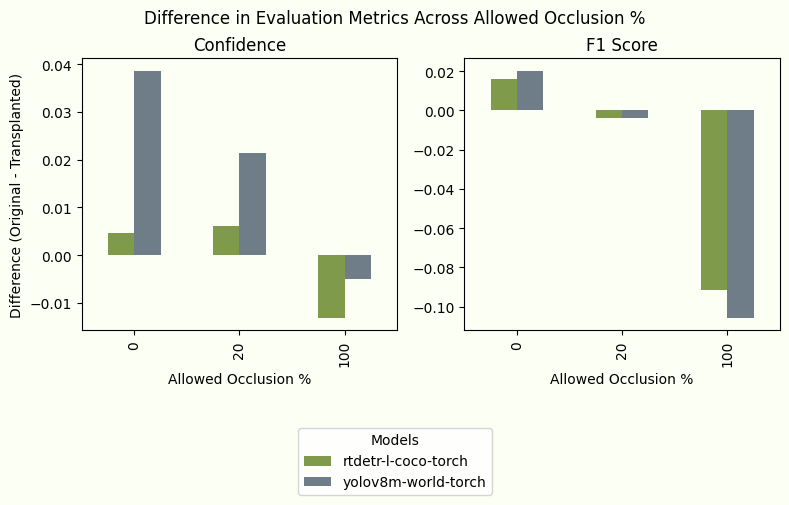

In [104]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_diff_mult(results):
    affected_values = ["conf", "f1"]
    custom_titles = ["Confidence", "F1 Score"]
    fig, axes = plt.subplots(nrows=1, ncols=len(affected_values), figsize=(8, 4), sharey=False)

    for i, affected_val in enumerate(affected_values):
        combined_data_diff = {}

        # Calculate the difference between original and transformed values, switching models and datasets
        for model in results[next(iter(results))].keys():  # Iterating over models
            combined_data_diff[model] = {}
            for dataset in results:
                og_value = results[dataset][model]['overall_og_mean_metrics'][affected_val]
                trans_value = results[dataset][model]['overall_trans_mean_metrics'][affected_val]
                combined_data_diff[model][dataset] = trans_value - og_value  # Store difference by model

        # Convert the difference data to a DataFrame with models as columns and datasets as index
        df_diff = pd.DataFrame(combined_data_diff)

        # Plot the difference in the affected value
        df_diff.plot(kind='bar', ax=axes[i], legend=False, color=colors[:len(df_diff.columns)])

        # Customize subplot
        axes[i].set_title(f'{custom_titles[i]}')
        axes[i].set_xlabel('Allowed Occlusion %')
        axes[i].set_facecolor('#f0f0f0')  # Background color for better visibility
        axes[i].set_facecolor(bg)
        if i == 0:
            axes[i].set_ylabel('Difference (Original - Transplanted)')

        # Collect legend handles and labels for the first plot only
        if i == 0:
            handles, labels = axes[i].get_legend_handles_labels()

    # Set a single legend for the entire figure
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1, title='Models')
    fig.patch.set_facecolor(bg)


    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle("Difference in Evaluation Metrics Across Allowed Occlusion %")

    # Show the plot
    plt.show()

# Call the function with the 'results' data
plot_diff_mult(results)
